<a href="https://colab.research.google.com/github/rgilyard/predict-student-outcomes/blob/main/prelim_rotation_forest_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminary Results for a Rotation Forest Classifier for Student Failure and Dropout Prediction

## Constants

In [ ]:
DATA_PATH = '/content/drive/MyDrive/COMP 542 Group Project/prelim_sample_engineered_student_info.csv'

## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Libraries

In [ ]:
import pandas as pd
import time

## Load data

In [ ]:
df = pd.read_csv(DATA_PATH)

In [ ]:
print(df.head())

   id_student gender            region            highest_education imd_band  \
0      646402      M          Scotland  Post Graduate Qualification   50-60%   
1      522538      F     London Region        A Level or Equivalent   50-60%   
2      675178      F             Wales        A Level or Equivalent   80-90%   
3      565273      F  Yorkshire Region        A Level or Equivalent   30-40%   
4      544519      F      North Region           Lower Than A Level    0-10%   

  age_band  num_of_prev_attempts  studied_credits disability final_result  \
0     0-35                     0              120          N         Pass   
1     0-35                     1               60          N    Withdrawn   
2     0-35                     0               60          N    Withdrawn   
3     0-35                     0              120          N  Distinction   
4     0-35                     0               60          N         Fail   

  course_instance  early_assessment_avg  
0       FFF_20

In [ ]:
# Drop id column
df.drop(['id_student'], axis=1, inplace=True)

## Preprocessing (These will be moved to a .py file later)

### Combine fail/withdraw and pass/distinction for binary prediction (at first)

In [ ]:
df['fail'] = df['final_result'].apply(lambda x: 1 if x in ['Fail', 'Withdrawn'] else 0)

### Split into training and test sets

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(['final_result', 'fail'], axis=1)  # Dropping the target columns
y = df['fail']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9001)

### Missing values

In [ ]:
# Check how many values are missing
print(X_train.isnull().sum())

gender                    0
region                    0
highest_education         0
imd_band                256
age_band                  0
num_of_prev_attempts      0
studied_credits           0
disability                0
course_instance           0
early_assessment_avg     19
dtype: int64


In [ ]:
# Since there are not too many missing values, we can take the mode for imd_band
X_train['imd_band'].fillna(X_train['imd_band'].mode()[0], inplace=True)
X_test['imd_band'].fillna(X_test['imd_band'].mode()[0], inplace=True)

# Mean imputation for early assessment grade average
X_train['early_assessment_avg'].fillna(X_train['early_assessment_avg'].mean(), inplace=True)
X_test['early_assessment_avg'].fillna(X_test['early_assessment_avg'].mean(), inplace=True)

print(X_train.isnull().sum())

gender                  0
region                  0
highest_education       0
imd_band                0
age_band                0
num_of_prev_attempts    0
studied_credits         0
disability              0
course_instance         0
early_assessment_avg    0
dtype: int64


### Label encode binary features

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [ ]:
# Lists for each type of feature to encode
# List of binary columns
binary = ['gender', 'disability']

# List of categorical columns
categorical = ['course_instance', 'region']

# List of ordinal columns
ordinal = {'highest_education': [\
              'No Formal quals', \
              'Lower Than A Level', \
              'A Level or Equivalent', \
              'HE Qualification', \
              'Post Graduate Qualification'], \
           'imd_band': [\
              '0-10%', \
              '10-20', \
              '20-30%', \
              '30-40%', \
              '40-50%', \
              '50-60%', \
              '60-70%', \
              '70-80%', \
              '80-90%', \
              '90-100%'], \
           'age_band': [\
              '0-35', \
              '35-55', \
              '55<=']}

In [ ]:
# Label encode binary features
label_encoder = LabelEncoder()

for feature in binary:
  label_encoder.fit(X_train[feature])
  X_train[feature] = label_encoder.transform(X_train[feature])
  X_test[feature] = label_encoder.transform(X_test[feature])

In [ ]:
# Label encode ordinal features in order
for feature, order in ordinal.items():
  label_encoder = LabelEncoder()
  label_encoder.fit(order)
  X_train[feature] = label_encoder.transform(X_train[feature])
  X_test[feature] = label_encoder.transform(X_test[feature])

In [ ]:
# One hot encode categorical features
X_train = pd.get_dummies(X_train, columns=categorical)
X_test = pd.get_dummies(X_test, columns=categorical)

In [ ]:
# Because there a some categories with very few instances,
# make sure all the features are in both sets
# Add the missing columns filled with zeros
for col in X_train.columns:
  if col not in X_test.columns:
    X_test[col] = 0

# Reorder test columns to match the order in training set
X_test = X_test[X_train.columns]

# Normalize data

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Train Rotation Forest Model

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

In [ ]:
# Rotation Forest Parameters
num_pca_components = 5
num_random_forests = 10

In [ ]:
# Rotation Forest Algorithm
def rotation_forest(X_train, y_train, num_pca_components, num_random_forests):
    base_classifiers = []
    for i in range(num_random_forests):
        # Apply PCA
        pca = PCA(n_components=num_pca_components)
        X_train_transformed = pca.fit_transform(X_train)

        # Train a Random Forest Classifier on the transformed data
        rf = RandomForestClassifier()
        rf.fit(X_train_transformed, y_train)

        # Store the PCA and Random Forest pair
        base_classifiers.append((pca, rf))

    return base_classifiers

# Time model training duration
start_time = time.time()
base_classifiers = rotation_forest(X_train, y_train, num_pca_components, num_random_forests)
# Record model train duration end time
end_time = time.time()

In [ ]:
elapsed_time = end_time - start_time
print(f"Time taken for training: {elapsed_time:.2f} seconds")

Time taken for training: 19.31 seconds


## Evaluate Model

In [ ]:
# Prediction function
def predict_proba_rotation_forest(X, base_classifiers):
    probabilities = []
    for pca, rf in base_classifiers:
        X_transformed = pca.transform(X)
        prob = rf.predict_proba(X_transformed)[:, 1]  # get probability of class 1
        probabilities.append(prob)

    # Average the probabilities
    avg_prob = np.mean(probabilities, axis=0)
    return avg_prob

y_prob = predict_proba_rotation_forest(X_test, base_classifiers)

### ROC curve

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [ ]:
# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
# Compute AUC
roc_auc = auc(fpr, tpr)

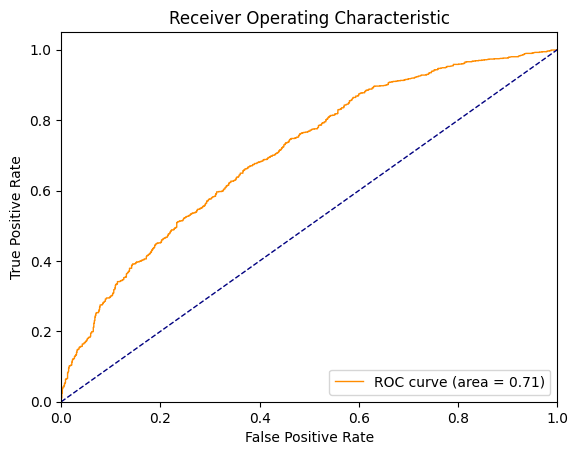

In [ ]:
# Plot figure
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()